In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import tqdm as notebook_tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
from transformers import BitsAndBytesConfig

model = "Qwen/Qwen2.5-1.5B"

'''#quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype="bfloat16"
)'''

tokenizer = AutoTokenizer.from_pretrained(model, trust_remote_code = True)
model = AutoModelForCausalLM.from_pretrained(model, device_map = 'auto', trust_remote_code = True)#quantization_config = bnb_config

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [9]:
model.eval()

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps=1e-06)
    (rotary_emb): Qw

In [5]:
#now checking how well it performs
import json
import pprint

with open('2.json', 'r') as f:
    test_ques_1 = json.load(f)

pprint.pprint(test_ques_1)




{'level': 'Level 4',
 'problem': 'We flip a fair coin 10 times.  What is the probability that we '
            'get heads in at least 6 of the 10 flips?',
 'solution': 'There are $2^{10} = 1024$ possible outcomes of the 10 coin '
             'flips. The probability that we flip at least 6 heads is equal to '
             'the probability that we flip at least 6 tails, by symmetry.  '
             "Let's call this probability $p$.  The only other possibility is "
             'that we flip exactly 5 heads and 5 tails, for which the '
             'probability is $\\dfrac{\\binom{10}{5}}{2^{10}} = '
             '\\dfrac{252}{1024} = \\dfrac{63}{256}$.  Therefore, '
             '$\\dfrac{63}{256} + 2p = 1$, giving $$ '
             'p=\\frac{1}{2}\\left(1-\\frac{63}{256}\\right)=\\boxed{\\frac{193}{512}} '
             '$$',
 'type': 'Counting & Probability'}


In [7]:
test_ques_1['problem']

'We flip a fair coin 10 times.  What is the probability that we get heads in at least 6 of the 10 flips?'

In [20]:
def generated_output(problem, solution, model,tokenizer, max_new_tokens: int = 1024):
  prompt = f"""Solve the following math problem step by step. Show all calculations. Give the final answer in **fraction form** and box it clearly at the end.

  Problem: {problem}
  """
  inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)

  with torch.no_grad():
      outputs = model.generate(**inputs, max_new_tokens=1024)

  generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return {
        "problem": problem,
        "original_answer": solution,
        "model_answer": generated_answer
    }



#Counting and Probability question

In [22]:
#evaluation = eval(test_data)
problem_1 = test_ques_1['problem']
solution_1 = test_ques_1['solution']

test_one = generated_output(problem_1, solution_1, model, tokenizer)
pprint.pprint(test_one)


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


{'model_answer': 'Solve the following math problem step by step. Show all '
                 'calculations. Give the final answer in **fraction form** and '
                 'box it clearly at the end.\n'
                 '\n'
                 '  Problem: We flip a fair coin 10 times.  What is the '
                 'probability that we get heads in at least 6 of the 10 '
                 'flips?\n'
                 '   To solve this problem, we can use the binomial '
                 'distribution. The binomial distribution is a probability '
                 'distribution that models the number of successes in a fixed '
                 'number of independent trials, where each trial has only two '
                 'possible outcomes: success or failure.\n'
                 '\n'
                 'In this case, we have a fair coin, so the probability of '
                 'getting heads (success) on any given flip is 1/2. We are '
                 'flipping the coin 10 times, so we ha

#Number theory question

In [23]:
#on different topic
#test_ques_2 = load_data('test','precalculus',21)
with open('/content/13.json', 'r') as f:
  test_ques_2 = json.load(f)

problem_2 = test_ques_2['problem']
solution_2 = test_ques_2['solution']

test_two = generated_output(problem_2, solution_2, model, tokenizer)
pprint.pprint(test_two)



Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


{'model_answer': 'Solve the following math problem step by step. Show all '
                 'calculations. Give the final answer in **fraction form** and '
                 'box it clearly at the end.\n'
                 '\n'
                 '  Problem: What is the average of the two smallest positive '
                 'integer solutions to the congruence $$14u \\equiv 46 '
                 '\\pmod{100}~?$$\n'
                 '   - **Step 1 of Calculation:** First, we need to simplify '
                 'the congruence equation. We can do this by dividing both '
                 'sides of the equation by the greatest common divisor (GCD) '
                 'of 14 and 46, which is 2. This gives us:\n'
                 '   \\[\n'
                 '   7u \\equiv 23 \\pmod{50}\n'
                 '   \\]\n'
                 '   - **Step 2 of Calculation:** Next, we need to find the '
                 'smallest positive integer solutions to this simplified '
                 'congruence

#intermediate_algebra question

In [24]:
with open('/content/137.json', 'r') as f:
  test_ques_3 = json.load(f)


problem_3 = test_ques_3['problem']
solution_3 = test_ques_3['solution']

test_three = generated_output(problem_3, solution_3, model, tokenizer)
pprint.pprint(test_three)



Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


{'model_answer': 'Solve the following math problem step by step. Show all '
                 'calculations. Give the final answer in **fraction form** and '
                 'box it clearly at the end.\n'
                 '\n'
                 '  Problem: Find the number of real roots to\n'
                 '\\[x^4 - 2x^2 - 7 = 0.\\]\n'
                 '   To find the number of real roots to the equation \\(x^4 - '
                 '2x^2 - 7 = 0\\), we can start by making a substitution. Let '
                 '\\(y = x^2\\). Then the equation becomes a quadratic '
                 'equation in terms of \\(y\\):\n'
                 '\n'
                 '\\[y^2 - 2y - 7 = 0.\\]\n'
                 '\n'
                 'We can solve this quadratic equation using the quadratic '
                 'formula \\(y = \\frac{-b \\pm \\sqrt{b^2 - 4ac}}{2a}\\), '
                 'where \\(a = 1\\), \\(b = -2\\), and \\(c = -7\\). Plugging '
                 'in these values, we get:\n'
       

Human-Evaluation: the model's answer is not good. It correctly prediction 1/3 question on manual evaluation.

In [ ]:
#on gm8k dataset
'''import joblib

X_train, X_test, y_train, y_test = joblib.load("split_data.joblib")'''


In [12]:
import pandas as pd
df = pd.read_csv('/kaggle/input/gm8k-new/gm8k_new.csv')
df.head()


,question,final_solution
0,Janet’s ducks lay 16 eggs per day. She eats th...,18
1,A robe takes 2 bolts of blue fiber and half th...,3
2,Josh decides to try flipping a house. He buys...,70000
3,James decides to run 3 sprints 3 times a week....,540
4,"Every day, Wendi feeds each of her chickens th...",20


In [13]:
from sklearn.model_selection import train_test_split
X = df['question']
y = df['final_solution']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [17]:

import torch
import re
import matplotlib.pyplot as plt

def predict_direct_answer(problem: str, model, tokenizer, max_new_tokens=30):
    prompt = f"Give only the final numerical answer to this math problem:\n{problem}\nAnswer:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens,
                                pad_token_id=tokenizer.eos_token_id )#last param to remove warning messg

    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    match = re.search(r"[-+]?\d*\.?\d+", output_text)
    return match.group() if match else "N/A"

def evaluate_model(X_test, y_test, model, tokenizer):
    results = []
    correct = 0

    for q, a in zip(X_test, y_test):
        predicted = predict_direct_answer(q, model, tokenizer)
        is_match = predicted == str(a).strip()
        results.append({'question': q, 'actual': str(a), 'predicted': predicted, 'match': is_match})
        if is_match:
            correct += 1

    accuracy = correct / len(X_test)
    return results, accuracy



In [18]:
def plot_pie(results):
    correct = sum(r['match'] for r in results)
    incorrect = len(results) - correct

    plt.figure(figsize=(6, 6))
    plt.pie(
        [correct, incorrect],
        labels=['Correct', 'Incorrect'],
        colors=['green', 'red'],
        autopct='%1.1f%%',
        startangle=140
    )
    plt.title("Model Accuracy on Test Dataset")
    plt.axis('equal')
    plt.show()


Accuracy: 2.27%


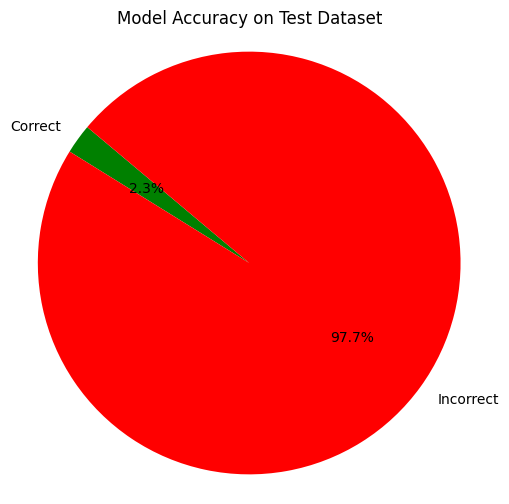


Question: Carol and Jennifer are sisters from Los Angeles who love collecting signatures from celebrities. During their summer break from school, the sisters spend every afternoon collecting signatures. After five weeks, Carol and Jennifer compare their autograph books, counting up the number of signatures each sister has collected. Carol has 20 signatures in her book, and Jennifer has 44. The sisters have three more weeks of summer vacation, and they decide they want to reach 100 signatures between them by the end of the summer. How many signatures do the sisters need to collect to reach their goal?
Predicted: 20 | Actual: 36

Question: A team of 4 painters worked on a mansion for 3/8ths of a day every day for 3 weeks. How many hours of work did each painter put in?
Predicted: 4 | Actual: 189

Question: It costs $194 per meter to repave a street. Monica's street is 150 meters long. How much more does it cost to repave Lewis' street, which is 490 meters long?
Predicted: 194 | Actual: 

In [22]:
results, accuracy = evaluate_model(X_test, y_test, model, tokenizer)
print(f"Accuracy: {accuracy:.2%}")

plot_pie(results)

#viwing few failed cases
for r in results:
    if not r['match']:
        print(f"\nQuestion: {r['question']}\nPredicted: {r['predicted']} | Actual: {r['actual']}")

Performed worst on the test dataset.